# 3 phase Bridge Diode Power converter 

The goal is to compare the SIMBA simulation results against theory calculation for this topology.

Let's compare the output average voltage and input rms current.

# SIMBA circuit
![bridge diode](bridge_diode.png)



Simulation settings : 
* predictive time step (variable) 
* minimum time step: 1E-06
* simulation time: 0.08s


# Theory calculation

* Average Output voltage

$ V_{<out>} =  \frac{V_{in} \times 3 \times \sqrt{6}}{\pi*\sqrt{2}} $

with V_in = 380

* Input RMS current

$ I_{input,rms} = I_{dc} \times \sqrt{\frac{2}{3}}  $

with I_dc=10


### Run Simulation 

In [1]:
# Load modules
from aesim.simba import JsonProjectRepository
from math import *
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
#Theory calculation for output average voltage and input rms current

Vinput = 380
Vo_th = (Vinput * 3 * sqrt(6))/(pi*sqrt(2))
print ("Theory Output voltage Average = ", Vo_th)

Idc_th=10
Iinput_rms = Idc_th * sqrt(2/3)
print ("Theory Input rms current = ", Iinput_rms)

Theory Output voltage Average =  628.5149407808428
Theory Input rms current =  8.16496580927726


In [3]:
# Load functions

# get steady state signals
def steadystate_signal(horizon_time, time, *signals):
    """steadystate_signal() returns time ndarray and a list of signals on the horizon_time"""

    steadystate_maskarray = np.ma.where(time > time[-1] - horizon_time)
    steadystate_time = time[steadystate_maskarray]
    steadystate_signal_list = [signal[steadystate_maskarray] 
for signal in signals]
    return steadystate_time, *steadystate_signal_list

# calculate average value
def average_value(time, waveform):
    """average_value() returns the average value of a time waveform equal time steps are not required"""

    cum_sum = 0
    range_idx = range(0, len(time)-1, 1)

    for idx in range_idx:
        cum_sum += (time[idx + 1] - time[idx]) * (waveform[idx+1] + waveform[idx]) /2
    return (1 / (time[-1] - time[0]) * cum_sum)

# calculate rms value
def rms_value(time, waveform):
    """rms_value() returns the rms value of a time waveform equal time steps are not required"""

    cum_sum = 0
    range_idx = range(0, len(time)-1, 1)

    for idx in range_idx:
        cum_sum += (time[idx + 1] - time[idx]) * (waveform[idx+1]**2 + waveform[idx]**2) /2
    return (np.sqrt(1 / (time[-1] - time[0]) * cum_sum))

# plot histogram
def plot_bar(Tab1 = [], 
        Tab2 = [], 
        largeur_barre = 0.3,
        Etiquette = [],
        FigAxe = "ax1",
        show = False,
        plot = plt, Tab1_abscisse = [], 
        dxticks = 0, mxticks = 2, 
        xlim = [], ylim = [],
        color_tab1 = 'orange',
        Legend = ['SIMBA', 'PSIM'],
        ylabel='Average or rms values'):
        """
        Tab1: donnée SIMBA
        Tab2: Donnée PSIM
        largeur_barre = 0.3 # Largeur de chaque barre :
        """

        if Tab1_abscisse == []:
                Tab1_abscisse = range(len(Tab1)) # Position des barres de la categorie 1
        
        if Tab2 != []:
                Tab2_abscisse = [i + largeur_barre for i in Tab1_abscisse] # Position des barres de la cat 2

        plot.bar(Tab1_abscisse, Tab1, width = largeur_barre, color = color_tab1, # Barres cat 1
                edgecolor = 'black', linewidth = 2)
        
        if Tab2 != []:
                plot.bar(Tab2_abscisse, Tab2, width = largeur_barre, color = 'yellow', # Barres cat 2
                        edgecolor = ['black' for i in Tab1], linewidth = 2)

        plot.xticks([dxticks+r + largeur_barre / mxticks for r in range(len(Tab1))], # Etiquettes
                Etiquette)

        FigAxe.set_ylabel(ylabel)

        if ylim !=[]:
                plt.ylim(ylim)
        if xlim !=[]:
                plt.xlim(xlim)

        if Tab2 != []:
            plot.legend(Legend)

        if show == True :
                plot.show()


========== 0 Error(s), 0 Warning(s) ==========
Job duration: 0,0092649 seconds.

SIMBA Output Voltage Average =  628.5175247445637
SIMBA Input current RMS =  8.164809015328022
 Diff_relative_mean for output voltage at steady state =  0.00041
 Diff_relative_rms for input current at steady state =  0.00192
Total simulation Time in SIMBA 0.0092649


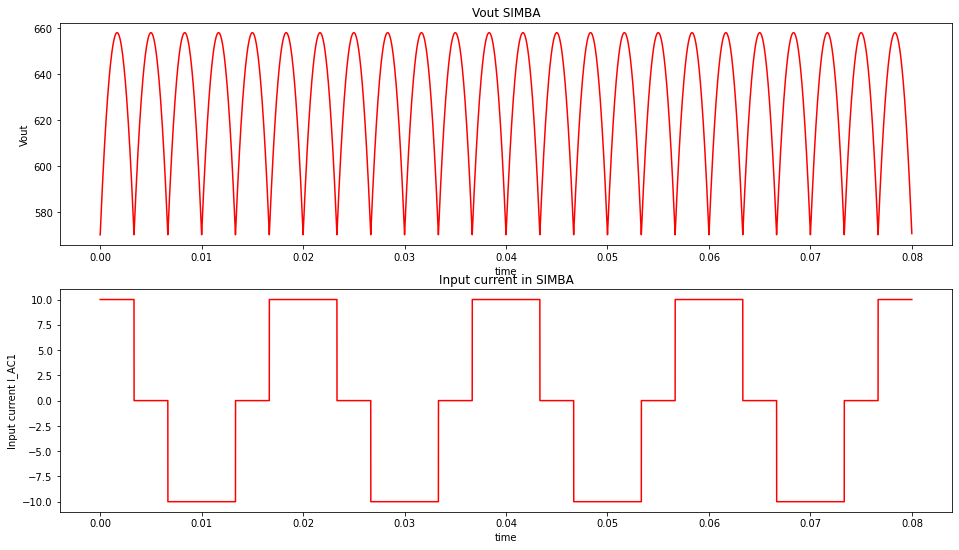

In [4]:
# Load SIMBA project
file_path = os.path.join(os.getcwd(), "3ph_bridge_diode.jsimba")
project = JsonProjectRepository(file_path)
AC_DC_bridge_diode = project.GetDesignByName('AC_DC_bridge_diode')

# Get the job object and solve the system
job = AC_DC_bridge_diode.TransientAnalysis.NewJob()
status = job.Run()
print(job.Summary())

# Get results
t = job.TimePoints
Vout = job.GetSignalByName('DC1 - Instantaneous Voltage').DataPoints
I_AC1 = job.GetSignalByName('AC1 - Instantaneous Current').DataPoints


# Plot graph for output voltage and input current during all simulation time
fig = plt.figure(figsize = (16, 9))

ax1 = fig.add_subplot(211)
plot1 = ax1.plot(t, Vout, "r")
ax1.set_xlabel('time')
ax1.set_ylabel('Vout')
ax1.set_title("Vout SIMBA")

ax4 = fig.add_subplot(212)
plot1 = ax4.plot(t, I_AC1, "r")
ax4.set_xlabel('time')
ax4.set_ylabel('Input current I_AC1')
ax4.set_title("Input current in SIMBA")


# steady state during 2 periods for the measurements comparison
fsw=50
horizon_time = 2 / fsw  
t, Vout, I_AC1 = steadystate_signal(
   horizon_time,
   np.array(job.TimePoints),
   np.array(job.GetSignalByName('DC1 - Instantaneous Voltage').DataPoints),
   np.array(job.GetSignalByName('AC1 - Instantaneous Current').DataPoints))

# Peform average calculation for DC signals and rms calculation for ac signals during 2 periods
Vout_average = average_value(t, Vout)
print("SIMBA Output Voltage Average = ", str(Vout_average))

I_AC1_rms = rms_value(t, I_AC1)
print("SIMBA Input current RMS = ", str(I_AC1_rms))

# calculation of relative difference between SIMBA & theoretical calculation at steady state
Diff_relative_mean = np.round(abs(Vo_th - Vout_average)*100/Vo_th, 5)
print (" Diff_relative_mean for output voltage at steady state = ", Diff_relative_mean)

Diff_relative_rms = np.round(abs(Iinput_rms - I_AC1_rms)*100/Iinput_rms, 5)
print (" Diff_relative_rms for input current at steady state = ", Diff_relative_rms)


#Retrieve total simulation time for SIMBA simulation
job.RunTime
print ("Total simulation Time in SIMBA", str(job.RunTime))


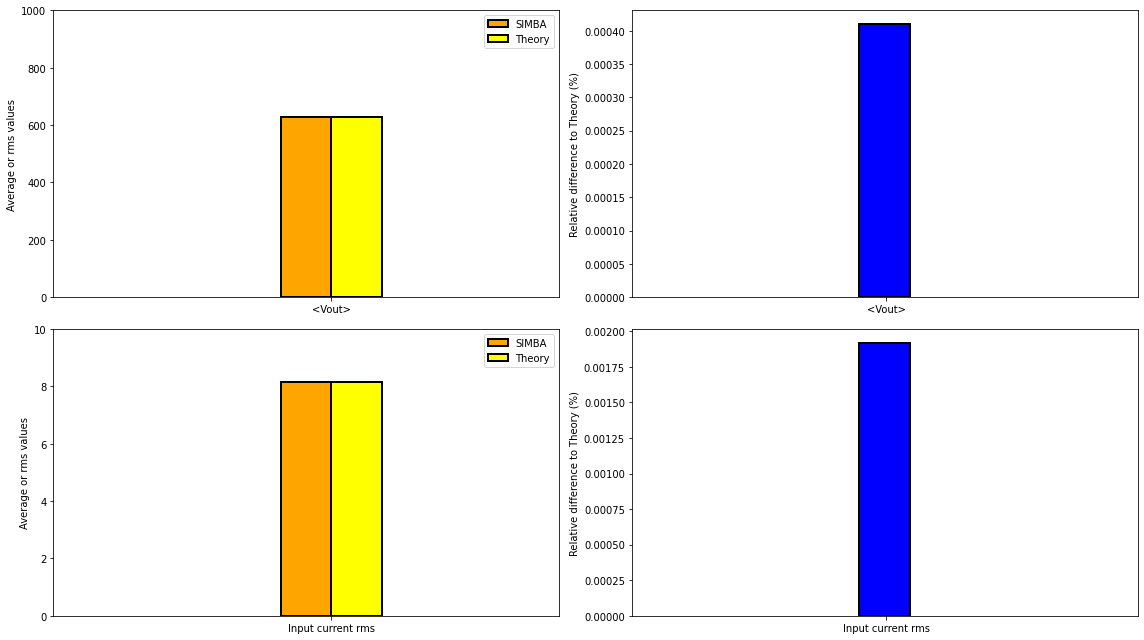

In [5]:
# Plot figure with both graphs and Histogram at steady state
fig1 = plt.figure(figsize = (16, 9))
ax2 = fig1.add_subplot(221)
plot_bar(Tab1 = [Vout_average],
        Tab2 = [Vo_th], 
        largeur_barre = 0.1,
        Etiquette = ['<Vout>'],
        Legend = ['SIMBA', 'Theory'],
        xlim = [0, 1], ylim = [0, 1000],
        Tab1_abscisse = [0.5], 
        dxticks= 0.5,
        FigAxe = ax2)


ax3 = fig1.add_subplot(222)
plot_bar(Tab1 = [Diff_relative_mean], 
        largeur_barre = 0.1,
        Etiquette = ['<Vout>'],
        FigAxe = ax3, 
        mxticks = 32,
        ylabel = 'Relative difference to Theory (%)',
        Tab1_abscisse = [0.5],
        xlim = [0, 1],
        dxticks= 0.5,
        color_tab1 = 'blue')


ax5 = fig1.add_subplot(223)
ax5.set_ylabel('Average or rms values')
plot_bar(Tab1 = [I_AC1_rms],
        Tab2 = [Iinput_rms], 
        largeur_barre = 0.1,
        Etiquette = ['Input current rms'],
        Legend = ['SIMBA', 'Theory'],
        xlim = [0, 1], ylim = [0, 10],
        Tab1_abscisse = [0.5], 
        dxticks= 0.5,
        FigAxe = ax2)



ax6 = fig1.add_subplot(224)
plot_bar(Tab1 = [Diff_relative_rms], 
        largeur_barre = 0.1,
        Etiquette = ['Input current rms'],
        FigAxe = ax6, 
        mxticks = 32,
        Tab1_abscisse = [0.5],
        xlim = [0, 1],
        dxticks= 0.5,
        ylabel = 'Relative difference to Theory (%)',
        color_tab1 = 'blue')


fig.tight_layout()
fig1.tight_layout()

plt.show()